# Demo: Exploring the VGG16 Networks

State-of-the-art deep networks have millions of parameters and often takes days to train, even with clusters of high-power GPUs. Unless you have time and lots of cloud credits to burn, reproducing these results is not possible. Fortunately, the `torchvision` package has many excellent *pre-trained* networks that achieve state-of-the-art performance.  By *pre-trained*, we mean that the weights have already been trained and you can just load the network and weights.  We can then use these networks for image predictions and other research problems.

In this demo, we will explore one of many possible state-of-the-art pre-trained deep networks in the `torchvision` package: VGG16.  The VGG16 network was first described in the paper:

> Karen Simonyan, Andrew Zisserman, [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556), arxiv 2014

The network was produced by the [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) at Oxford University and obtained first and second place in the ImageNet 2014 challenge.

In this demo, you will see how to:
* Load a pre-trained network in the `torchvision` package
* Make predictions on new images with the network
* Obtain outputs of intermediate layers.

## Loading the Network

We first load the `torch` package. 

In [1]:
import torch

Then, we import some other standard packages

In [2]:
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we load `torchvision.models`, which contains the the VGG16 pretrained network.  A complete list of the pre-trained networks available are given on the [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html) page.

In [3]:
# Load appropriate packages
import torchvision.models as models

We now download the model with the pre-trained weights.  This can several minutes if you have not downloaded it before, since it will fetch the `.pth` model description file from PyTorch's server.  Note the file is very large, about 500 MB.  So, make sure you have disk space.  If not, consider doing this in the cloud, for example, on Google Cloud Platform.

In [4]:
model = models.vgg16(pretrained=True)

We now print the entries in the model's `state_dict` in order to see how the different layers are constructed.
As seen below, there are sections to the network: a `features` section, an `avgpool` section, and a `classifier` section.  The `features` and `classifier` sections are a sequence of several modules.

In [5]:
print(str(model))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Loading Test Images

We illustrate the network on a test set of elephant images.  We will assume that we have 10 images, which are stored in a directory as follows:

    test/elephant/elephant_0000.jpg
    test/elephant/elephant_0001.jpg
    ...
    test/elephant/elephant_0009.jpg
    
Each image should be color, but can have any shape.  You can follow [demo_cnn_flickr](../Demos/demo_cnn_flickr.ipynb) to create this dataset.

We will create a batch of these images using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder) tool (which expects a directory structure of the form above) to load and transform the data, and then creating a DataLoader to batch the data, as before.

In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Create a transformation that converts to a tensor then and crops to a desired size (we'll do 224x224)
crop = transforms.CenterCrop(224)
transform = transforms.Compose([crop, transforms.ToTensor()])
# Create a DataSet, using our transform and folder
dataset = ImageFolder(root='test', transform=transform)
# Create a DataLoader, given a desired batch size
batch_size = 10
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

Then, we load a batch of images using the data loader

In [7]:
x, y = next(iter(loader))

We now display a few of the images.  Some images may look unnatural due to cropping.

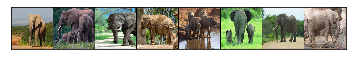

In [8]:
from torchvision.utils import make_grid

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

show(make_grid(x[0:8,:,:,:]))

## Making Predictions on the Images

Now that we have created a batch of images, we can use the network to make predictions on the object class.  First, the images must be normalized. If we weren't displaying the original images as above, we would add this normalization step into the `transform` used to create the DataSet.

In [9]:
# This normalization transform is standard for imagenet problems
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

for i in range(batch_size):
    x[i,:,:,:] = normalize(x[i,:,:,:])

We then run the images through the network to make the predictions. We will need to load a dictionary to decode the output.

In [ ]:
import requests
import torch.nn as nn

# compute model predictions for images in batch x
model.eval()
with torch.no_grad():
    output = model(x)
    output = nn.functional.softmax(output, dim=1)

# Get label dictionary (code from https://sparrow.dev/pytorch-quick-start-classifying-an-image/)
LABELS_URL = 'https://jbencook.s3.amazonaws.com/pytorch-quick-start/labels.json'
labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

# Compute top 3 categories
ntop = 3  
top3_pct, top3_idx = output.topk(ntop)
top3_pct = top3_pct.numpy()
top3_idx = top3_idx.numpy()

# Extract class strings
top3_cat = np.chararray([batch_size,ntop],itemsize=15)
for item in range(batch_size):
    for k in range(ntop):
        top3_cat[item, k] = labels[top3_idx[item,k]]

For each image in the batch, the matrix `top3_idx` contains the indices of the top 3 predicted classes, the matrix `top3_pct` contains the corresponding confidences (in percent), and `top3_cat` contains the corresponding class strings.

We display the decoded results as a pandas dataframe. 

In [ ]:
import pandas as pd

res_dict = {}
for i in range(ntop):
    class_name = []
    class_prob = []
    for j in range(batch_size):
        class_name.append(top3_cat[j,i])
        class_prob.append(top3_pct[j,i])

    name_col = str('class %d' % i)
    prob_col = str('prob %d' % i)
    res_dict[name_col] = class_name
    res_dict[prob_col] = class_prob
        
df = pd.DataFrame(data=res_dict)

for i in range(ntop):
    name_col = str('class %d' % i)
    df[name_col] = df[name_col].str.decode('utf-8') # avoid ugly bytestring stuff

df

## Get Intermediate Outputs

It is often useful to look at the outputs of intermediate layers.  This is easily done in `pytorch`.  Suppose we want to look at the outputs of `fc1` and `block4_conv2`.  Then, we create a new model, `model_int` with these two outputs as follows:

In [ ]:
# see https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/12
class FeatureExtractor(nn.Module):
    def __init__(self, model, feature_layers, classifier_layers):
        super(FeatureExtractor,self).__init__()
        self.model = model
        self.feature_layers = feature_layers
        self.classifier_layers = classifier_layers

    def forward(self, x):
        feature_outputs = []
        classifier_outputs = []
        # feature modules
        for name, module in self.model.features._modules.items():
            x = module(x)
            if name in self.feature_layers:
                feature_outputs += [x]
        
        # avgpool module (used to deal with image size different from 224x224 pixels)
        x = self.model.avgpool(x)
        x = x.view(x.size(0),-1) # flatten
        
        # classifier modules
        for name, module in self.model.classifier._modules.items():
            x = module(x)
            if name in self.classifier_layers:
                classifier_outputs += [x]
                
        return x, feature_outputs, classifier_outputs

Now we can create a model that will save intermediate layers

In [ ]:
feature_module_list = ['20'] # this is the activation after the 9th conv layer (see str(model) above)
classifier_module_list = ['2'] # this is the activation after the first fully connected layer
activation_extractor_model = FeatureExtractor(model, feature_module_list, classifier_module_list)
activation_extractor_model.eval()
with torch.no_grad():
    out, y_feat, y_class = activation_extractor_model(x)

The output `y` is a list with two outputs -- one for each layer.  We print the CDF of the output of the values from each layer.  We observe a key feature of the outputs.  More than 75% of the coefficients are zero, meaning that deep network creates *sparse* representations.

In [ ]:
y1 = np.sort(y_feat[0].cpu().numpy().ravel())
n1 = len(y1)

plt.subplot(1,2,1)
plt.plot(np.arange(n1)/n1, y1[::-1])
plt.title('feature module' + feature_module_list[0])

y2 = np.sort(y_class[0].cpu().numpy().ravel())
n2 = len(y2)

plt.subplot(1,2,2)
plt.plot(np.arange(n2)/n2, y2[::-1])
plt.title('classifier module' + classifier_module_list[0])
    


## Visualize the output channels of different feature layers

From a list of layers that we'd like to inspect, we extract the outputs using the function created above.

In [ ]:
feature_module_list = ['1', '4', '9', '16', '23', '30'] # List of modules to inspect
classifier_module_list = [] # We will only look at the above feature modules
activation_extractor_model = FeatureExtractor(model, feature_module_list, classifier_module_list)
activation_extractor_model.eval()
with torch.no_grad():
    out, y_feat, y_class = activation_extractor_model(x)

Before plotting the output of each layer, we make a plot function and plot the input to the network (in each color channel).

In [ ]:
# Display a grayscale image
def disp_image(im):
    plt.imshow(im, cmap='gray')    

    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(20,20))
nplot = 3
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(x[-1,i,:,:])
    plt.title('original image, channel %d' % (i))

Next we go through the extracted layers and plot the first 4 channels of each.

In [ ]:
nplot = 4
indx = 0
print(y_feat[indx].size())

In [ ]:
plt.figure(figsize=(20,20))
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y_feat[indx][-1,i,:,:])
    plt.title('feature module %s, channel %d' % (feature_module_list[indx],i))

In [ ]:
indx = 1
print(y_feat[indx].shape)

In [ ]:
plt.figure(figsize=(20,20))
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y_feat[indx][-1,i,:,:])
    plt.title('feature module %s, channel %d' % (feature_module_list[indx],i))

In [ ]:
indx = 2
print(y_feat[indx].size())

In [ ]:
plt.figure(figsize=(20,20))
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y_feat[indx][-1,i,:,:])
    plt.title('feature module %s, channel %d' % (feature_module_list[indx],i))

In [ ]:
indx = 3
print(y_feat[indx].size())

In [ ]:
plt.figure(figsize=(20,20))
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y_feat[indx][-1,i,:,:])
    plt.title('feature module %s, channel %d' % (feature_module_list[indx],i))

In [ ]:
indx = 4
print(y_feat[indx].size())

In [ ]:
plt.figure(figsize=(20,20))
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y_feat[indx][-1,i,:,:])
    plt.title('feature module %s, channel %d' % (feature_module_list[indx],i))

In [ ]:
indx = 5
print(y_feat[indx].size())

In [ ]:
plt.figure(figsize=(20,20))
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y_feat[indx][-1,i,:,:])
    plt.title('feature module %s, channel %d' % (feature_module_list[indx],i))